## 1. Imports & chargement


In [1]:
from dotenv import load_dotenv
import os

load_dotenv()
os.chdir("..")

In [2]:
# imports
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt

# config et chemins
cfg_path = Path("config.yaml")
import yaml
cfg = yaml.safe_load(open(cfg_path))
inter_dir = Path(cfg["paths"]["data"]["interim"])
processed_dir = Path(cfg["paths"]["data"]["processed"])
processed_dir.mkdir(parents=True, exist_ok=True)

# liste des zones
zones = [p.stem.replace("_interim_hourly","")
         for p in inter_dir.glob("*_interim_hourly.pkl")]


In [3]:
print(zones)

['Baleares', 'Canarias', 'Ceuta', 'El_Hierro', 'Gran_canaria', 'Lanzarote_Fuerteventura', 'La_Gomera', 'La_Palma', 'Melilla', 'nacional', 'Peninsule_Iberique', 'Tenerife']


## 2. Degrés-jours (HDD/CDD)

In [4]:
# fonctions HDD / CDD
def add_degree_days(df, base_temp=18.0):
    df["HDD"] = np.maximum(0, base_temp - df["temperature_2m"])
    df["CDD"] = np.maximum(0, df["temperature_2m"] - base_temp)
    return df


## 3. Indices de confort

In [5]:
def compute_heat_index(T, RH):
    # formule simplifiée de Rothfusz (approx)
    return -8.7847 + 1.6114*T + 2.3385*RH - 0.1461*T*RH \
           - 0.0123*T**2 - 0.0164*RH**2 + 0.0022*T**2*RH \
           + 0.0007*T*RH**2 - 0.0000*T**2*RH**2

def add_comfort_indices(df):
    df["HeatIndex"] = compute_heat_index(df["temperature_2m"],
                                         df["relative_humidity_2m"])
    # Wind Chill si T<=10°C et vent>4.8km/h (conversion m/s→km/h*)
    v_kmh = df["wind_speed_10m"] * 3.6
    df["WindChill"] = np.where(
        (df["temperature_2m"] <= 10) & (v_kmh > 4.8),
        13.12 + 0.6215*df["temperature_2m"] - 11.37*v_kmh**0.16
        + 0.3965*df["temperature_2m"]*v_kmh**0.16,
        df["temperature_2m"]
    )
    return df


## 4. Fenêtres glissantes météo et prix

In [6]:
# rolling windows pour variables clés
def add_rolling_features(df):
    windows = [3, 12, 24, 7, 14, 30, 365]  # en heures ou jours
    for w in windows:
        df[f"temp_rmean_{w}"] = df["temperature_2m"].rolling(w).mean()
        df[f"pvpc_rmean_{w}"] = df["pvpc"].rolling(w).mean()
        df[f"rad_rsum_{w}"]   = df["shortwave_radiation"].rolling(w).sum()
    return df


## 5. Encodages cycliques et calendaires

In [7]:
# encodages cycliques et saisons
def add_cyclic_time_features(df):
    idx = df.index
    df["hour"]    = idx.hour
    df["hour_sin"] = np.sin(2*np.pi*df["hour"]/24)
    df["hour_cos"] = np.cos(2*np.pi*df["hour"]/24)

    df["dayofweek"]  = idx.dayofweek
    df["dow_sin"]    = np.sin(2*np.pi*df["dayofweek"]/7)
    df["dow_cos"]    = np.cos(2*np.pi*df["dayofweek"]/7)

    df["month"]   = idx.month
    df["mth_sin"] = np.sin(2*np.pi*(df["month"]-1)/12)
    df["mth_cos"] = np.cos(2*np.pi*(df["month"]-1)/12)

    df["season"] = ((idx.month % 12 + 3)//3).astype(int)  # 1=hiver,2=printemps…
    return df


## 6. Interactions et transformations non linéaires

In [8]:
# interactions supplémentaires
def add_interactions(df):
    # Interaction entre température et humidité relative
    df["T_x_RH"] = df["temperature_2m"] * df["relative_humidity_2m"]
    
    # Carré de la température
    df["T_sq"] = df["temperature_2m"] ** 2
    
    # Interaction entre prix PVPC et température
    df["pvpc_x_T"] = df["pvpc"] * df["temperature_2m"]
    
    # Interaction entre radiation solaire et température
    if "shortwave_radiation" in df.columns:
        df["rad_x_T"] = df["shortwave_radiation"] * df["temperature_2m"]
    
    # Interaction entre radiation solaire et humidité relative
    if "shortwave_radiation" in df.columns:
        df["rad_x_RH"] = df["shortwave_radiation"] * df["relative_humidity_2m"]
    
    # Interaction entre vitesse du vent et température
    if "wind_speed_10m" in df.columns:
        df["wind_x_T"] = df["wind_speed_10m"] * df["temperature_2m"]
    
    # Interaction entre vitesse du vent et humidité relative
    if "wind_speed_10m" in df.columns:
        df["wind_x_RH"] = df["wind_speed_10m"] * df["relative_humidity_2m"]
    
    # Interaction entre radiation solaire et prix PVPC
    if "shortwave_radiation" in df.columns:
        df["rad_x_pvpc"] = df["shortwave_radiation"] * df["pvpc"]
    
    return df


## 7. Sélection de features

In [9]:
# mutual information et importance simple
def select_features(df, target="demand", top_k=20, drop_na_thresh=0.2, random_state=0):
    # Retirer les colonnes avec trop de NaN
    na_frac = df.isna().mean()
    cols_keep = na_frac[na_frac < drop_na_thresh].index.tolist()
    if target not in cols_keep:
        cols_keep.append(target)
    df = df[cols_keep].copy()
    
    # Remplir les NaN restants
    X = df.drop(columns=[target]).fillna(df.median(numeric_only=True))
    y = df[target].values

    # Mutual information
    mi = mutual_info_regression(X, y, discrete_features=False, random_state=random_state)
    mi_s = pd.Series(mi, index=X.columns).sort_values(ascending=False)
    return mi_s.head(top_k)


lag_1h            1.615070
lag_24h           1.560409
lag_168h          1.213771
lag_2h            1.006715
lag_3h            0.694872
lag_4h            0.525600
dayofyear         0.477822
rmean_7d          0.450600
lag_5h            0.434340
temperature_2m    0.412538
dtype: float64

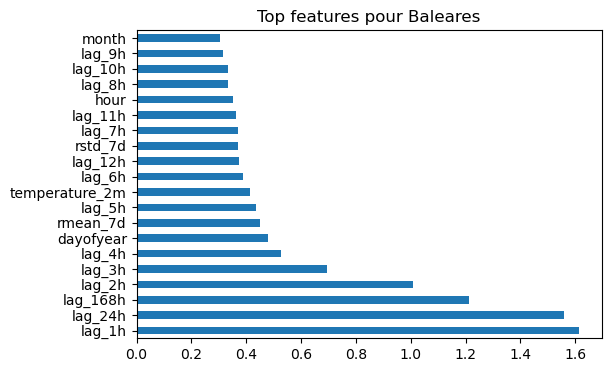

In [10]:
# Exemple d’affichage pour la première zone
mi_top = select_features(
    pd.read_pickle(inter_dir/f"{zones[0]}_interim_hourly.pkl")
)
display(mi_top.head(10))
mi_top.plot.barh(figsize=(6,4))
plt.title(f"Top features pour {zones[0]}")
plt.show()

lag_1d            1.305263
rmean_7d          0.986214
lag_2d            0.917925
lag_7d            0.917214
lag_3d            0.865363
lag_6d            0.816989
lag_4d            0.801699
temperature_2m    0.777302
lag_5d            0.774307
lag_365d          0.514790
dtype: float64

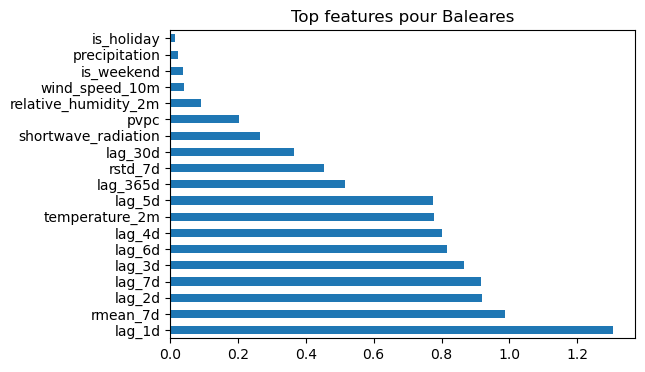

In [11]:
# Exemple d’affichage pour la première zone
mi_top = select_features(
    pd.read_pickle(inter_dir/f"{zones[0]}_interim_daily.pkl")
)
display(mi_top.head(10))
mi_top.plot.barh(figsize=(6,4))
plt.title(f"Top features pour {zones[0]}")
plt.show()

## 8. Boucle complète et export final

In [12]:
# pipeline feature engineering et sauvegarde processed
list_of_features_keep = []
for zone in zones:
    print(f"→ Feature engineering {zone}")
    df = pd.read_pickle(inter_dir/f"{zone}_interim_hourly.pkl")

    df = add_degree_days(df)
    df = add_comfort_indices(df)
    df = add_rolling_features(df)
    df = add_cyclic_time_features(df)
    df = add_interactions(df)
    # on peut réutiliser fill_missing si des Na restent
    df = df.ffill().bfill()

    df = df["2019-01-01":]

    # on peut garder les features de la liste ci-dessous
    features_to_keep = ["demand", "lag_1h", "lag_2h", "lag_3h", "lag_4h", "lag_6h", "lag_12h", "lag_24h"]
    features_to_keep += select_features(df, top_k= 12).index.tolist() 

    features_to_keep = list(set(features_to_keep))
    list_of_features_keep.append((zone, features_to_keep))

    # on ne garde que les features sélectionnées
    df_e = df[features_to_keep][:"2024-01-02"]
    df_s = df[features_to_keep]["2024-01-02":]

    # Export final en Parquet
    out_path_e = processed_dir/f"{zone}_processed_hourly.parquet"
    out_path_s = processed_dir/".."/"submission"/f"{zone}_processed_hourly.parquet"

    df_e.to_parquet(out_path_e, index=True)
    df_s.to_parquet(out_path_s, index=True)
    print(f"   • saved {out_path_e.name}")

# sauvegarde des features sélectionnées
features_df = pd.DataFrame(list_of_features_keep, columns=["zone", "features"])
features_df.to_csv(processed_dir/".."/"submission"/"features_selected_hourly.csv", index=False)

→ Feature engineering Baleares
   • saved Baleares_processed_hourly.parquet
→ Feature engineering Canarias
   • saved Canarias_processed_hourly.parquet
→ Feature engineering Ceuta
   • saved Ceuta_processed_hourly.parquet
→ Feature engineering El_Hierro
   • saved El_Hierro_processed_hourly.parquet
→ Feature engineering Gran_canaria
   • saved Gran_canaria_processed_hourly.parquet
→ Feature engineering Lanzarote_Fuerteventura
   • saved Lanzarote_Fuerteventura_processed_hourly.parquet
→ Feature engineering La_Gomera
   • saved La_Gomera_processed_hourly.parquet
→ Feature engineering La_Palma
   • saved La_Palma_processed_hourly.parquet
→ Feature engineering Melilla
   • saved Melilla_processed_hourly.parquet
→ Feature engineering nacional
   • saved nacional_processed_hourly.parquet
→ Feature engineering Peninsule_Iberique
   • saved Peninsule_Iberique_processed_hourly.parquet
→ Feature engineering Tenerife
   • saved Tenerife_processed_hourly.parquet


In [16]:
# pipeline feature engineering et sauvegarde processed
list_of_features_keep = []
for zone in zones:
    print(f"→ Feature engineering {zone}")
    df = pd.read_pickle(inter_dir/f"{zone}_interim_daily.pkl")

    df = add_degree_days(df)
    df = add_comfort_indices(df)
    df = add_rolling_features(df)
    df = add_cyclic_time_features(df)
    df = add_interactions(df)
    # on peut réutiliser fill_missing si des Na restent
    df = df.ffill().bfill()

    df = df["2016-05-01":] if zone != "nacional" else df["2019-01-01":]

    # on peut garder les features de la liste ci-dessous
    features_to_keep = ["demand", "lag_1d", "lag_2d", "lag_3d", "lag_7d", "lag_30d"]
    features_to_keep += select_features(df, top_k= 13).index.tolist() 

    features_to_keep = list(set(features_to_keep))
    list_of_features_keep.append((zone, features_to_keep))

    # on ne garde que les features sélectionnées
    df_e = df[features_to_keep][:"2024-01-02"]
    df_s = df[features_to_keep]["2024-01-02":]

    # Export final en Parquet
    out_path_e = processed_dir/f"{zone}_processed_daily.parquet"
    out_path_s = processed_dir/".."/"submission"/f"{zone}_processed_daily.parquet"
    
    df_e.to_parquet(out_path_e, index=True)
    df_s.to_parquet(out_path_s, index=True)
    print(f"   • saved {out_path_e.name}")

# sauvegarde des features sélectionnées
features_df = pd.DataFrame(list_of_features_keep, columns=["zone", "features"])
features_df.to_csv(processed_dir/".."/"submission"/"features_selected_daily.csv", index=False)

→ Feature engineering Baleares
   • saved Baleares_processed_daily.parquet
→ Feature engineering Canarias
   • saved Baleares_processed_daily.parquet
→ Feature engineering Canarias
   • saved Canarias_processed_daily.parquet
→ Feature engineering Ceuta
   • saved Canarias_processed_daily.parquet
→ Feature engineering Ceuta
   • saved Ceuta_processed_daily.parquet
→ Feature engineering El_Hierro
   • saved Ceuta_processed_daily.parquet
→ Feature engineering El_Hierro
   • saved El_Hierro_processed_daily.parquet
→ Feature engineering Gran_canaria
   • saved El_Hierro_processed_daily.parquet
→ Feature engineering Gran_canaria
   • saved Gran_canaria_processed_daily.parquet
→ Feature engineering Lanzarote_Fuerteventura
   • saved Gran_canaria_processed_daily.parquet
→ Feature engineering Lanzarote_Fuerteventura
   • saved Lanzarote_Fuerteventura_processed_daily.parquet
→ Feature engineering La_Gomera
   • saved Lanzarote_Fuerteventura_processed_daily.parquet
→ Feature engineering La_Gomera

# Résumé final du notebook

Ce notebook a permis de réaliser les étapes suivantes pour l'ingénierie des features sur les données de demande énergétique :

- Chargement des données intermédiaires pour chaque zone.
- Création de nouvelles variables météorologiques (degrés-jours, indices de confort).
- Génération de variables glissantes (rolling means/sums) sur température, prix et radiation.
- Encodages cycliques et calendaires (heures, jours, mois, saisons).
- Création d'interactions et de transformations non linéaires.
- Sélection automatique des variables les plus pertinentes via la mutual information.
- Export des datasets finaux (features sélectionnées) au format Parquet pour chaque zone, en version horaire et journalière.
- Sauvegarde des listes de variables retenues pour chaque zone.

Les fichiers générés se trouvent dans les dossiers :
- `data/processed/` : données enrichies prêtes pour la modélisation
- `data/submission/` : données pour la soumission finale et listes de features sélectionnées

Ces fichiers seront utilisés pour l'entraînement et l'évaluation de vos modèles de prévision.